In [1]:
from os.path import dirname, join, basename, isfile
from tqdm import tqdm

from models import SyncNet_color as SyncNet
from models import Wav2Lip as Wav2Lip
import audio

import torch
from torch import nn
from torch import optim
import torch.backends.cudnn as cudnn
from torch.utils import data as data_utils
import numpy as np

from glob import glob

import os, random, cv2, argparse
from hparams import hparams, get_image_list

####################################################
import sklearn
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

## Define variables

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--data_root", help="Root folder of the preprocessed LRS2 dataset", required=True, type=str)
parser.add_argument('--checkpoint_dir', help='Save checkpoints to this directory', required=True, type=str)
parser.add_argument('--syncnet_checkpoint_path', help='Load the pre-trained Expert discriminator', required=True, type=str)
parser.add_argument('--checkpoint_path', help='Resume from this checkpoint', default=None, type=str)

_StoreAction(option_strings=['--checkpoint_path'], dest='checkpoint_path', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, required=False, help='Resume from this checkpoint', metavar=None)

In [3]:
data_root = "C:\\Users\\ioann\\Desktop\\projects\\Github\\Wav2Lip\\data\\lrs2_preprocessed"
checkpoint_dir = "C:\\Users\\ioann\\Desktop\\projects\\Github\\Wav2Lip\\checkpoints\\wav2lip"
syncnet_checkpoint_path = "C:\\Users\\ioann\\Desktop\\projects\\Github\\Wav2Lip\\checkpoints\\syncnet\\checkpoint_step000000001.pth"

args = parser.parse_args(args = ["--data_root", data_root,
                                 "--checkpoint_dir", checkpoint_dir,
                                 "--syncnet_checkpoint_path", syncnet_checkpoint_path])

In [4]:
global_step = 0
global_epoch = 0
use_cuda = torch.cuda.is_available()
print('use_cuda: {}'.format(use_cuda))

syncnet_T = 5
syncnet_mel_step_size = 16

use_cuda: True


## Define dataset

In [5]:
class Dataset(object):
    def __init__(self, split):
        self.all_videos = get_image_list(args.data_root, split)

    def get_frame_id(self, frame):
        return int(basename(frame).split('.')[0])

    def get_window(self, start_frame):
        start_id = self.get_frame_id(start_frame)
        vidname = dirname(start_frame)

        window_fnames = []
        for frame_id in range(start_id, start_id + syncnet_T):
            frame = join(vidname, '{}.jpg'.format(frame_id))
            if not isfile(frame):
                return None
            window_fnames.append(frame)
        return window_fnames

    def read_window(self, window_fnames):
        if window_fnames is None: return None
        window = []
        for fname in window_fnames:
            img = cv2.imread(fname)
            if img is None:
                return None
            try:
                img = cv2.resize(img, (hparams.img_size, hparams.img_size))
            except Exception as e:
                return None

            window.append(img)

        return window

    def crop_audio_window(self, spec, start_frame):
        if type(start_frame) == int:
            start_frame_num = start_frame
        else:
            start_frame_num = self.get_frame_id(start_frame) # 0-indexing ---> 1-indexing
        start_idx = int(80. * (start_frame_num / float(hparams.fps)))
        
        end_idx = start_idx + syncnet_mel_step_size

        return spec[start_idx : end_idx, :]

    def get_segmented_mels(self, spec, start_frame):
        mels = []
        assert syncnet_T == 5
        start_frame_num = self.get_frame_id(start_frame) + 1 # 0-indexing ---> 1-indexing
        if start_frame_num - 2 < 0: return None
        for i in range(start_frame_num, start_frame_num + syncnet_T):
            m = self.crop_audio_window(spec, i - 2)
            if m.shape[0] != syncnet_mel_step_size:
                return None
            mels.append(m.T)

        mels = np.asarray(mels)

        return mels

    def prepare_window(self, window):
        # 3 * T x H x W
        x = np.asarray(window) / 255. # T x H x W x 3
        x = np.transpose(x, (3, 0, 1, 2)) # 3 x T x H x W

        return x

    def __len__(self):
        return len(self.all_videos)

    def __getitem__(self, idx):
        while 1:
            idx = random.randint(0, len(self.all_videos) - 1)
            vidname = self.all_videos[idx]
            img_names = list(glob(join(vidname, '*.jpg')))
            if len(img_names) <= 3 * syncnet_T:
                continue
            
            img_name = random.choice(img_names)
            wrong_img_name = random.choice(img_names)
            while wrong_img_name == img_name:
                wrong_img_name = random.choice(img_names)

            window_fnames = self.get_window(img_name)
            wrong_window_fnames = self.get_window(wrong_img_name)
            if window_fnames is None or wrong_window_fnames is None:
                continue

            window = self.read_window(window_fnames)
            if window is None:
                continue

            wrong_window = self.read_window(wrong_window_fnames)
            if wrong_window is None:
                continue

            try:
                wavpath = join(vidname, "audio.wav")
                wav = audio.load_wav(wavpath, hparams.sample_rate)

                orig_mel = audio.melspectrogram(wav).T
            except Exception as e:
                continue

            mel = self.crop_audio_window(orig_mel.copy(), img_name)
            
            if (mel.shape[0] != syncnet_mel_step_size):
                continue

            indiv_mels = self.get_segmented_mels(orig_mel.copy(), img_name)
            if indiv_mels is None: continue

            window = self.prepare_window(window)
            y = window.copy()
            window[:, :, window.shape[2]//2:] = 0.

            wrong_window = self.prepare_window(wrong_window)
            x = np.concatenate([window, wrong_window], axis=0)

            x = torch.FloatTensor(x)
            mel = torch.FloatTensor(mel.T).unsqueeze(0)
            indiv_mels = torch.FloatTensor(indiv_mels).unsqueeze(1)
            y = torch.FloatTensor(y)
            return x, indiv_mels, mel, y

In [6]:
train_li, val_li = train_test_split(["\\".join(i.split("\\")[-2:]) for i in glob(os.path.join(args.data_root, "*/*"))], train_size=0.8, shuffle=True, random_state=1)

with open('C:/Users/ioann/Desktop/projects/Github/Wav2Lip/filelists/train.txt', 'w') as f:
    for line in train_li:
        f.write(f"{line}\n")

with open('C:/Users/ioann/Desktop/projects/Github/Wav2Lip/filelists/val.txt', 'w') as f:
    for line in val_li:
        f.write(f"{line}\n")

In [7]:
checkpoint_dir = args.checkpoint_dir

# Dataset and Dataloader setup
train_dataset = Dataset('train')
test_dataset = Dataset('val')

In [8]:
x, indiv_mels, mel, y = train_dataset.__getitem__(1)

c:\Users\ioann\Desktop\projects\Github\Wav2Lip\audio.py:100: FutureWarning: Pass sr=16000, n_fft=800 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.filters.mel(hp.sample_rate, hp.n_fft, n_mels=hp.num_mels,


In [18]:
y.shape

torch.Size([3, 5, 96, 96])

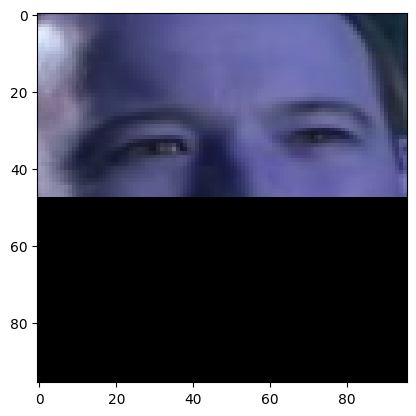

In [9]:
window = x[:3, :]
plt.imshow(window[:, 0, :, :].detach().cpu().permute(1,2,0).numpy())
plt.show()

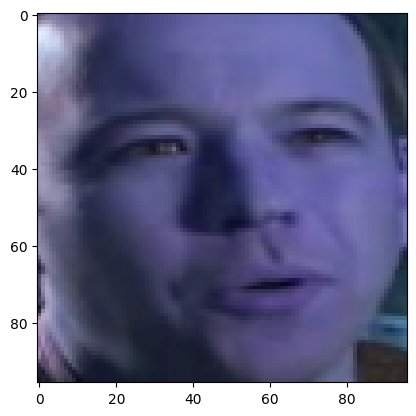

In [10]:
plt.imshow(y[:, 0, :, :].detach().cpu().permute(1,2,0).numpy())
plt.show()

## Functions

In [19]:
def save_sample_images(x, g, gt, global_step, checkpoint_dir):
    x = (x.detach().cpu().numpy().transpose(0, 2, 3, 4, 1) * 255.).astype(np.uint8)
    g = (g.detach().cpu().numpy().transpose(0, 2, 3, 4, 1) * 255.).astype(np.uint8)
    gt = (gt.detach().cpu().numpy().transpose(0, 2, 3, 4, 1) * 255.).astype(np.uint8)

    refs, inps = x[..., 3:], x[..., :3]
    folder = join(checkpoint_dir, "samples_step{:09d}".format(global_step))
    if not os.path.exists(folder): os.mkdir(folder)
    collage = np.concatenate((refs, inps, g, gt), axis=-2)
    for batch_idx, c in enumerate(collage):
        for t in range(len(c)):
            cv2.imwrite('{}/{}_{}.jpg'.format(folder, batch_idx, t), c[t])

logloss = nn.BCELoss()
def cosine_loss(a, v, y):
    d = nn.functional.cosine_similarity(a, v)
    loss = logloss(d.unsqueeze(1), y)

    return loss

device = torch.device("cuda" if use_cuda else "cpu")
syncnet = SyncNet().to(device)
for p in syncnet.parameters():
    p.requires_grad = False

recon_loss = nn.L1Loss()
def get_sync_loss(mel, g):
    g = g[:, :, :, g.size(3)//2:]
    g = torch.cat([g[:, :, i] for i in range(syncnet_T)], dim=1)
    # B, 3 * T, H//2, W
    a, v = syncnet(mel, g)
    y = torch.ones(g.size(0), 1).float().to(device)
    return cosine_loss(a, v, y)

def train(device, model, train_data_loader, test_data_loader, optimizer,
          checkpoint_dir=None, checkpoint_interval=None, nepochs=None):
    '''
    part of the paper contribution is to use an input in the identity encoder, a random frame R 
    concatenated with a pose-prior P (target face with lower-half masked)
    '''

    global global_step, global_epoch
    resumed_step = global_step
 
    while global_epoch < nepochs:
        print('Starting Epoch: {}'.format(global_epoch))
        running_sync_loss, running_l1_loss = 0., 0.
        prog_bar = tqdm(enumerate(train_data_loader))
        for step, (x, indiv_mels, mel, gt) in prog_bar:
            model.train()
            optimizer.zero_grad()

            # Move data to CUDA device
            x = x.to(device)
            mel = mel.to(device)
            indiv_mels = indiv_mels.to(device)
            gt = gt.to(device)

            # enables model  to learn general info on the audio content
            g = model(indiv_mels, x)

            if hparams.syncnet_wt > 0.:
                sync_loss = get_sync_loss(mel, g) # using expect sync model to evaluate how good the generator (frames) match the ground truth melspectrogram
            else:
                sync_loss = 0.

            l1loss = recon_loss(g, gt)

            loss = hparams.syncnet_wt * sync_loss + (1 - hparams.syncnet_wt) * l1loss
            loss.backward()
            optimizer.step()

            if global_step % checkpoint_interval == 0:
                save_sample_images(x, g, gt, global_step, checkpoint_dir)

            global_step += 1
            cur_session_steps = global_step - resumed_step

            running_l1_loss += l1loss.item()
            if hparams.syncnet_wt > 0.:
                running_sync_loss += sync_loss.item()
            else:
                running_sync_loss += 0.

            if global_step == 1 or global_step % checkpoint_interval == 0:
                save_checkpoint(
                    model, optimizer, global_step, checkpoint_dir, global_epoch)

            if global_step == 1 or global_step % hparams.eval_interval == 0:
                with torch.no_grad():
                    average_sync_loss = eval_model(test_data_loader, global_step, device, model, checkpoint_dir)

                    if average_sync_loss < .75:
                        hparams.set_hparam('syncnet_wt', 0.01) # without image GAN a lesser weight is sufficient

            prog_bar.set_description('L1: {}, Sync Loss: {}'.format(running_l1_loss / (step + 1),
                                                                    running_sync_loss / (step + 1)))

        global_epoch += 1
        

def eval_model(test_data_loader, global_step, device, model, checkpoint_dir):
    eval_steps = 700
    print('Evaluating for {} steps'.format(eval_steps))
    sync_losses, recon_losses = [], []
    step = 0
    while 1:
        for x, indiv_mels, mel, gt in test_data_loader:
            step += 1
            model.eval()

            # Move data to CUDA device
            x = x.to(device)
            gt = gt.to(device)
            indiv_mels = indiv_mels.to(device)
            mel = mel.to(device)

            g = model(indiv_mels, x)

            sync_loss = get_sync_loss(mel, g)
            l1loss = recon_loss(g, gt)

            sync_losses.append(sync_loss.item())
            recon_losses.append(l1loss.item())

            if step > eval_steps: 
                averaged_sync_loss = sum(sync_losses) / len(sync_losses)
                averaged_recon_loss = sum(recon_losses) / len(recon_losses)

                print('L1: {}, Sync loss: {}'.format(averaged_recon_loss, averaged_sync_loss))

                return averaged_sync_loss

def save_checkpoint(model, optimizer, step, checkpoint_dir, epoch):

    checkpoint_path = join(
        checkpoint_dir, "checkpoint_step{:09d}.pth".format(global_step))
    optimizer_state = optimizer.state_dict() if hparams.save_optimizer_state else None
    torch.save({
        "state_dict": model.state_dict(),
        "optimizer": optimizer_state,
        "global_step": step,
        "global_epoch": epoch,
    }, checkpoint_path)
    print("Saved checkpoint:", checkpoint_path)


def _load(checkpoint_path):
    if use_cuda:
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path,
                                map_location=lambda storage, loc: storage)
    return checkpoint

def load_checkpoint(path, model, optimizer, reset_optimizer=False, overwrite_global_states=True):
    global global_step
    global global_epoch

    print("Load checkpoint from: {}".format(path))
    checkpoint = _load(path)
    s = checkpoint["state_dict"]
    new_s = {}
    for k, v in s.items():
        new_s[k.replace('module.', '')] = v
    model.load_state_dict(new_s)
    if not reset_optimizer:
        optimizer_state = checkpoint["optimizer"]
        if optimizer_state is not None:
            print("Load optimizer state from {}".format(path))
            optimizer.load_state_dict(checkpoint["optimizer"])
    if overwrite_global_states:
        global_step = checkpoint["global_step"]
        global_epoch = checkpoint["global_epoch"]

    return model

## Train model

In [21]:
# Dataset and Dataloader setup
train_dataset = Dataset('train')
test_dataset = Dataset('val')

train_data_loader = data_utils.DataLoader(
    train_dataset, batch_size=hparams.batch_size, shuffle=True,
    num_workers=hparams.num_workers)

test_data_loader = data_utils.DataLoader(
    test_dataset, batch_size=hparams.batch_size,
    num_workers=4)

device = torch.device("cuda" if use_cuda else "cpu")

In [22]:
# Model
model = Wav2Lip().to(device)
print('total trainable params {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad],
                        lr=hparams.initial_learning_rate)

total trainable params 36298035


In [ ]:
# Train!
train(device, model, train_data_loader, test_data_loader, optimizer,
            checkpoint_dir=checkpoint_dir,
            checkpoint_interval=hparams.checkpoint_interval,
            nepochs=hparams.nepochs)

Starting Epoch: 0


0it [00:00, ?it/s]

Saved checkpoint: C:\Users\ioann\Desktop\projects\Github\Wav2Lip\checkpoints\wav2lip\checkpoint_step000000001.pth
Evaluating for 700 steps
